<a href="https://colab.research.google.com/github/harry-erskine/PRBX-Travel-Mode-Identification/blob/main/ML_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ML - Decision Trees**

### **Data Preferences**

In [ ]:
### VARIABLES ###

groupSize = 16                   # How many trajectories are represented in each group
motion_points = groupSize - 3    # Do not change this variable

# variables below all 'True' or 'False' (where all 'False' represents the most filtered version of the data)

include_impossible_groups = False      # include groups with trajectories that I have deemed to be invalid
include_stationary_groups = False      # include groups where there is less than 3 meters of total movement
include_airplane_and_boat = False      # include groups where the mode of transportation was 'airplane' or 'boat'
include_all_time_ranges =   False      # include groups where the time between each trajectory is more than 1 second

### **Notebook Setup**

In [ ]:
### INSTALLS ###

# !pip install --upgrade gspread
# !pip install pandas
# !pip install scikit-learn

In [ ]:
### IMPORTS ###

import os
from google.colab import drive
import pandas as pd
import numpy as np
import time
#
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
### MOUNT GOOGLE DRIVE ###

mainMountPath = '/content/gdrive'
mainDrivePath = '/content/gdrive/MyDrive/Colab Notebooks/PRBX'

drive.mount(mainMountPath, force_remount=True)

Mounted at /content/gdrive


In [ ]:
### FILE PATHS ###

generatedFilesPath = mainDrivePath + '/Data Files/Generated Files'
cleanedMotionDataPath = generatedFilesPath + '/cleanedMotionDataX' + str(groupSize) + '.csv'

In [ ]:
cmdf = pd.read_csv(cleanedMotionDataPath)
cmdf = cmdf.drop('Unnamed: 0', axis=1)

In [ ]:
# shuffle the dataframe into a random order
df = cmdf.sample(frac=1).reset_index(drop=True)

# remove unwanted data
if include_impossible_groups == False:
  df = df[df['Impossible'] == False]

if include_stationary_groups == False:
  df = df[df['Stationary'] == False]

if include_airplane_and_boat == False:
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)
  df.drop(df[df['Mode'] == 'boat'].index, inplace=True)

if include_all_time_ranges == False:
  df = df[df['DT Max'] == 1]

df

,GroupId,UserId,Mode,Old Mode,S0,S1,S2,S3,S4,S5,...,AA RC6,BR RC0,BR RC1,BR RC2,BR RC3,BR RC4,BR RC5,BR RC6,Impossible,Stationary
9,36275,20,bike,bike,5.348541,4.194721,3.578580,3.154054,3.861917,3.161068,...,0,4,2,4,3,0,0,0,False,False
11,222147,163,train,train,12.417813,12.177964,12.115848,11.771558,12.209939,12.050584,...,0,13,0,0,0,0,0,0,False,False
12,34015,20,bike,bike,4.165760,4.054382,4.286974,3.921632,3.728316,3.861649,...,0,6,5,2,0,0,0,0,False,False
19,238455,167,bike,bike,0.880244,0.965145,2.713634,2.349903,0.671658,0.924476,...,3,4,4,1,1,2,0,1,False,False
22,36560,20,bike,bike,4.810655,2.991559,3.226270,4.434313,4.138110,5.781679,...,0,7,2,4,0,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261384,246760,167,bike,bike,2.999151,2.997935,2.455120,2.686633,2.796803,3.569489,...,0,7,5,1,0,0,0,0,False,False
261412,152630,85,train,subway,15.975689,15.969366,16.958180,17.893486,17.009729,17.094245,...,0,13,0,0,0,0,0,0,False,False
261420,29350,20,walk,walk,0.623931,0.142368,0.339589,3.272739,1.695470,2.101850,...,0,2,0,3,3,3,1,1,False,False
261421,243166,167,car,taxi,2.718241,2.796827,2.865409,2.408004,2.514441,5.113923,...,0,9,2,2,0,0,0,0,False,False


In [ ]:
print(df['Mode'].unique())

['bike' 'train' 'walk' 'bus' 'car']


In [ ]:
# Names of raw motion features
raw_speed_features =          [f'S{i}' for i in range(motion_points)]
raw_acceleration_features =   [f'A{i}' for i in range(motion_points)]
raw_jerk_features =           [f'J{i}' for i in range(motion_points)]
raw_alti_velocity_features =  [f'AV{i}' for i in range(motion_points)]
raw_alti_accel_features =     [f'AA{i}' for i in range(motion_points)]
raw_bearing_rate_features =   [f'BR{i}' for i in range(motion_points)]

raw_motion_features = raw_speed_features + raw_acceleration_features + raw_jerk_features + \
                      raw_alti_velocity_features + raw_bearing_rate_features

In [ ]:
# Names of derived motion features
derived_speed_features =          ['S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR']
derived_acceleration_features =   ['A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR']
derived_jerk_features =           ['J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR']
derived_alti_velocity_features =  ['AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR']
derived_alti_accel_features =     ['AA Min', 'AA 25% Q', 'AA Mean', 'AA Median', 'AA 75% Q', 'AA Max', 'AA Range', 'AA IQR']
derived_bearing_rate_features =   ['BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR']

# another way of formatting names of derived motion features
min_features =     ['S Min',    'A Min',    'J Min',    'AV Min',    'AA Min',      'BR Min']
q25_features =     ['S 25% Q',  'A 25% Q',  'J 25% Q',  'AV 25% Q',  'AA 25% Q',    'BR 25% Q']
mean_features =    ['S Mean',   'A Mean',   'J Mean',   'AV Mean',   'AA Mean',     'BR Mean']
median_features =  ['S Median', 'A Median', 'J Median', 'AV Median', 'AA Median',   'BR Median']
q75_features =     ['S 75% Q',  'A 75% Q',  'J 75% Q',  'AV 75% Q',  'AA 75% Q',  'BR 75% Q']
max_features =     ['S Max',    'A Max',    'J Max',    'AV Max',    'AA Max',      'BR Max']
range_features =   ['S Range',  'A Range',  'J Range',  'AV Range',  'AA Range',    'BR Range']
iqr_features =     ['S IQR',    'A IQR',    'J IQR',    'AV IQR',    'AA IQR',      'BR IQR']

# derived_motion_features =   derived_speed_features + derived_acceleration_features + derived_jerk_features + \
#                             derived_alti_velocity_features + derived_bearing_rate_features

derived_motion_features =  min_features + mean_features + q75_features + \
                           max_features + range_features + iqr_features

In [ ]:
# Names of range count features
speed_rc_features =         [f'S RC{i}' for i in range(7)]
acceleration_rc_features =  [f'A RC{i}' for i in range(7)]
jerk_rc_features =          [f'J RC{i}' for i in range(7)]
alti_velocity_rc_features = [f'AV RC{i}' for i in range(7)]
alti_accel_rc_features =    [f'AA RC{i}' for i in range(7)]
bearing_rate_rc_features =  [f'BR RC{i}' for i in range(7)]

# Concatenate all range count features
range_counts_features =  speed_rc_features + acceleration_rc_features + jerk_rc_features + \
                        alti_velocity_rc_features + bearing_rate_rc_features

In [ ]:
# Names of all useable features
all_features = raw_motion_features + derived_motion_features + range_counts_features
print(all_features)

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'AV0', 'AV1', 'AV2', 'AV3', 'AV4', 'AV5', 'AV6', 'AV7', 'AV8', 'AV9', 'AV10', 'AV11', 'AV12', 'BR0', 'BR1', 'BR2', 'BR3', 'BR4', 'BR5', 'BR6', 'BR7', 'BR8', 'BR9', 'BR10', 'BR11', 'BR12', 'S Min', 'A Min', 'J Min', 'AV Min', 'AA Min', 'BR Min', 'S Mean', 'A Mean', 'J Mean', 'AV Mean', 'AA Mean', 'BR Mean', 'S 75% Q', 'A 75% Q', 'J 75% Q', 'AV 75% Q', 'AA 75% Q', 'BR 75% Q', 'S Max', 'A Max', 'J Max', 'AV Max', 'AA Max', 'BR Max', 'S Range', 'A Range', 'J Range', 'AV Range', 'AA Range', 'BR Range', 'S IQR', 'A IQR', 'J IQR', 'AV IQR', 'AA IQR', 'BR IQR', 'S RC0', 'S RC1', 'S RC2', 'S RC3', 'S RC4', 'S RC5', 'S RC6', 'A RC0', 'A RC1', 'A RC2', 'A RC3', 'A RC4', 'A RC5', 'A RC6', 'J RC0', 'J RC1', 'J RC2', 'J RC3', 'J RC4', 'J RC5', 'J RC6', 'AV RC0

### **Small decision Tree**

This code was based on: https://www.kaggle.com/code/gizemtanriver/multi-class-classification-by-decision-tree

In [ ]:
features = derived_motion_features + range_counts_features
X = df.loc[:, features].values
y = df.loc[:, 'Mode']

In [ ]:
labelencoder_X = LabelEncoder()
X[:,1] = labelencoder_X.fit_transform(X[:,1])

# encoding categorical data
y,class_names = pd.factorize(y)

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

In [ ]:
# Fitting Classifier to the Training Set
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=2, random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

Training Accuracy: 0.72


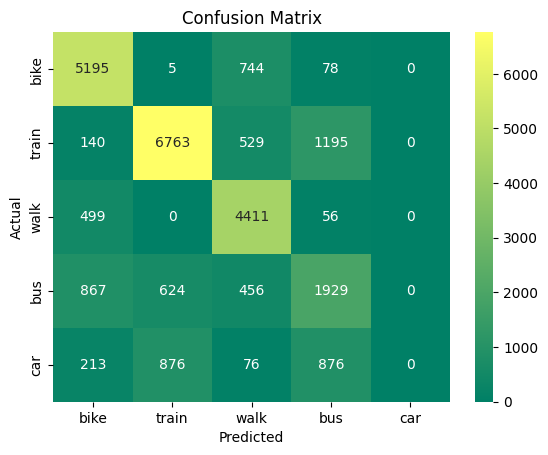

              precision    recall  f1-score   support

        bike       0.75      0.86      0.80      6022
       train       0.82      0.78      0.80      8627
        walk       0.71      0.89      0.79      4966
         bus       0.47      0.50      0.48      3876
         car       0.00      0.00      0.00      2041

    accuracy                           0.72     25532
   macro avg       0.55      0.61      0.57     25532
weighted avg       0.66      0.72      0.69     25532



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Model performance on training set
y_pred_train = classifier.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Training Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, cmap='summer', fmt='g',
                xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_train, y_pred_train, target_names=class_names))


Test Accuracy: 0.72


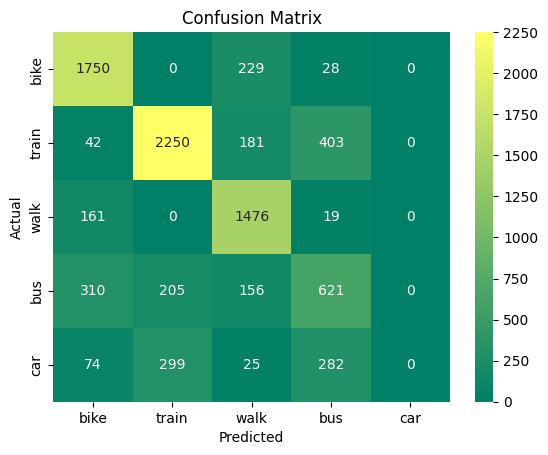

              precision    recall  f1-score   support

        bike       0.75      0.87      0.81      2007
       train       0.82      0.78      0.80      2876
        walk       0.71      0.89      0.79      1656
         bus       0.46      0.48      0.47      1292
         car       0.00      0.00      0.00       680

    accuracy                           0.72      8511
   macro avg       0.55      0.61      0.57      8511
weighted avg       0.66      0.72      0.69      8511



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Predicting the test results
y_pred = classifier.predict(X_test)

# Classification results on test set
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_test,y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, cmap='summer', fmt='g',
                xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))

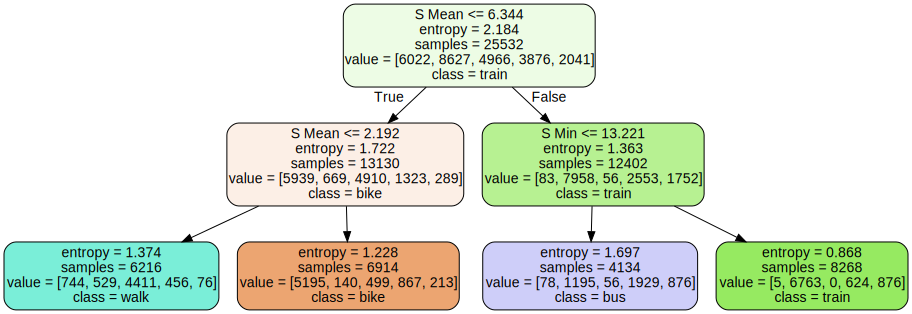

In [ ]:
# Visualize the tree by graphiz

dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=features, class_names=class_names)
graph = graphviz.Source(dot_data)
graph

In [ ]:
df_sorted = df.sort_values(by='S 25% Q', ascending=False)[['S 25% Q', 'Mode', 'S Mean', 'S Median']]
df_sorted.head(10)

,S 25% Q,Mode,S Mean,S Median
52712,65.993914,train,66.287249,66.214140
31650,65.552217,train,65.811493,65.783758
128834,65.551071,train,66.047420,65.775277
83906,64.660151,train,64.764895,64.770846
9032,64.324831,train,64.537899,64.445840
167277,63.832003,train,64.138750,64.165946
84915,63.750096,train,64.344916,63.835200
223690,63.369885,train,63.781918,63.673471
53094,63.160907,train,63.803945,63.874578
192201,63.011874,train,63.291327,63.120733


### **Decision Tree v0 (Control Group)**

This version of the decision tree will use only the raw motion data to show how accurate it can be with without any derived values fed into it.

This Tree will also have a max depth of 10 (which is fairly generous).

This code was based on: https://www.kaggle.com/code/gizemtanriver/multi-class-classification-by-decision-tree

This is the same code base as for 'Decision Tree V1'

In [ ]:
features = raw_motion_features

print(features)

X = df.loc[:, features].values
y = df.loc[:, 'Mode']

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18', 'J19', 'J20', 'J21', 'J22', 'J23', 'J24', 'J25', 'J26', 'J27', 'J28', 'AV0', 'AV1', 'AV2', 'AV3', 'AV4', 'AV5', 'AV6', 'AV7', 'AV8', 'AV9', 'AV10', 'AV11', 'AV12', 'AV13', 'AV14', 'AV15', 'AV16', 'AV17', 'AV18', 'AV19', 'AV20', 'AV21', 'AV22', 'AV23', 'AV24', 'AV25', 'AV26', 'AV27', 'AV28', 'BR0', 'BR1', 'BR2', 'BR3', 'BR4', 'BR5', 'BR6', 'BR7', 'BR8', 'BR9', 'BR10', 'BR11', 'BR12', 'BR13', 'BR14', 'BR15', 'BR16', 'BR17', 'BR18', 'BR19', 'BR20', 'BR21', 'BR22', 'BR23', 'BR24', 'BR25', 

In [ ]:
labelencoder_X = LabelEncoder()
X[:,1] = labelencoder_X.fit_transform(X[:,1])

# encoding categorical data
y,class_names = pd.factorize(y)

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

In [ ]:
# Fitting Classifier to the Training Set
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=10, random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [ ]:
# Model performance on training set
y_pred_train = classifier.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Training Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('\nConfusion Matrix: \n', cm, "\n")
print(classification_report(y_train, y_pred_train, target_names=class_names))

Training Accuracy: 0.88

Confusion Matrix: 
 [[3653   73   34   14   81]
 [  47 1928    3   81    9]
 [ 360   15  375   18   67]
 [   6   96    5 2597   21]
 [ 199   62   74   81 1128]] 

              precision    recall  f1-score   support

       train       0.86      0.95      0.90      3855
        walk       0.89      0.93      0.91      2068
         car       0.76      0.45      0.57       835
        bike       0.93      0.95      0.94      2725
         bus       0.86      0.73      0.79      1544

    accuracy                           0.88     11027
   macro avg       0.86      0.80      0.82     11027
weighted avg       0.87      0.88      0.87     11027



In [ ]:
# Predicting the test results
y_pred = classifier.predict(X_test)

# Classification results on test set
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_test,y_pred)
print('\nConfusion Matrix: \n', cm,"\n")
print(classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.74

Confusion Matrix: 
 [[1099   48   43   20   75]
 [  32  551    6   75   25]
 [ 148    6   41   20   64]
 [  13   71   11  773   40]
 [ 118   39   66   54  238]] 

              precision    recall  f1-score   support

       train       0.78      0.86      0.82      1285
        walk       0.77      0.80      0.78       689
         car       0.25      0.15      0.18       279
        bike       0.82      0.85      0.84       908
         bus       0.54      0.46      0.50       515

    accuracy                           0.74      3676
   macro avg       0.63      0.62      0.62      3676
weighted avg       0.71      0.74      0.72      3676



In [ ]:
# # Visualize the tree by graphiz

# dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=features, class_names=class_names)
# graph = graphviz.Source(dot_data)
# graph

### **Decision Tree v1**

This code was based on: https://www.kaggle.com/code/gizemtanriver/multi-class-classification-by-decision-tree

It is a simple decision tree with:

* All derived motion features
* All range counts features

In [ ]:
# # Exclude range and iqr from derived motion and range count features
# features = [feature for feature in derived_motion_features + range_counts_features
#                               if feature not in range_features + iqr_features]

features = derived_motion_features + range_counts_features

print(features)

X = df.loc[:, features].values
y = df.loc[:, 'Mode']

['S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR', 'A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR', 'J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR', 'AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR', 'BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR', 'S RC0', 'S RC1', 'S RC2', 'S RC3', 'S RC4', 'S RC5', 'S RC6', 'A RC0', 'A RC1', 'A RC2', 'A RC3', 'A RC4', 'A RC5', 'A RC6', 'J RC0', 'J RC1', 'J RC2', 'J RC3', 'J RC4', 'J RC5', 'J RC6', 'AV RC0', 'AV RC1', 'AV RC2', 'AV RC3', 'AV RC4', 'AV RC5', 'AV RC6', 'BR RC0', 'BR RC1', 'BR RC2', 'BR RC3', 'BR RC4', 'BR RC5', 'BR RC6']


In [ ]:
labelencoder_X = LabelEncoder()
X[:,1] = labelencoder_X.fit_transform(X[:,1])

# encoding categorical data
y,class_names = pd.factorize(y)

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

In [ ]:
# Fitting Classifier to the Training Set
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=10, random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [ ]:
# Model performance on training set
y_pred_train = classifier.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Training Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('\nConfusion Matrix: \n', cm, "\n")
print(classification_report(y_train, y_pred_train, target_names=class_names))

Training Accuracy: 0.87

Confusion Matrix: 
 [[3675   52   50   12   66]
 [  84 1882    0   88   14]
 [ 350    4  398   10   73]
 [  20  122    2 2547   34]
 [ 208   80   93   68 1095]] 

              precision    recall  f1-score   support

       train       0.85      0.95      0.90      3855
        walk       0.88      0.91      0.89      2068
         car       0.73      0.48      0.58       835
        bike       0.93      0.93      0.93      2725
         bus       0.85      0.71      0.77      1544

    accuracy                           0.87     11027
   macro avg       0.85      0.80      0.82     11027
weighted avg       0.87      0.87      0.86     11027



In [ ]:
# Predicting the test results
y_pred = classifier.predict(X_test)

# Classification results on test set
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_test,y_pred)
print('\nConfusion Matrix: \n', cm,"\n")
print(classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.79

Confusion Matrix: 
 [[1154   32   39    8   52]
 [  44  575    2   50   18]
 [ 136    8   84   11   40]
 [  19   64    4  789   32]
 [  95   35   42   51  292]] 

              precision    recall  f1-score   support

       train       0.80      0.90      0.84      1285
        walk       0.81      0.83      0.82       689
         car       0.49      0.30      0.37       279
        bike       0.87      0.87      0.87       908
         bus       0.67      0.57      0.62       515

    accuracy                           0.79      3676
   macro avg       0.73      0.69      0.70      3676
weighted avg       0.78      0.79      0.78      3676



In [ ]:
# Visualize the tree by graphiz

# dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=features, class_names=class_names)
# graph = graphviz.Source(dot_data)
# graph

### **Decision Tree (derived features + range counts)**

This code is bases from: https://www.kaggle.com/code/gideon94/multiclass-classification-svm-knn-dt-comparison

In [ ]:
#Feature selection
all_features = df[derived_motion_features + range_counts_features]
target_feature = df['Mode']
all_features.head()

,S Min,S 25% Q,S Mean,S Median,S 75% Q,S Max,S Range,S IQR,A Min,A 25% Q,...,AV RC4,AV RC5,AV RC6,BR RC0,BR RC1,BR RC2,BR RC3,BR RC4,BR RC5,BR RC6
5,12.450244,13.394560,14.705613,14.559387,15.927024,16.891870,4.441626,2.532464,-1.670193,-0.648016,...,0,0,0,29,0,0,0,0,0,0
18,0.341734,0.880534,1.429016,1.366935,1.816469,4.661099,4.319365,0.935934,-3.612123,-0.326635,...,0,0,0,4,2,7,8,7,1,0
24,0.713994,1.219127,1.352334,1.375689,1.505557,2.211916,1.497922,0.286430,-1.101605,-0.182432,...,14,0,0,11,8,4,4,2,0,0
31,0.339588,0.925285,1.340478,1.396408,1.697938,2.717336,2.377748,0.772653,-1.269594,-0.317394,...,0,0,0,7,6,6,5,3,2,0
36,16.789482,17.138495,17.502119,17.482079,17.793808,18.643745,1.854264,0.655313,-0.883016,-0.420840,...,5,1,0,29,0,0,0,0,0,0


In [ ]:
#Dataset preprocessing
x = all_features.values.astype(float) #returns a numpy array of type float
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_features = pd.DataFrame(x_scaled)
scaled_features.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.194916,0.207766,0.224051,0.223241,0.242143,0.248723,0.095816,0.152894,0.954084,0.800603,...,0.000000,0.000000,0.0,1.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0
1,0.005350,0.013658,0.020264,0.020959,0.027616,0.066113,0.093037,0.056506,0.895698,0.869483,...,0.000000,0.000000,0.0,0.137931,0.111111,0.4375,0.5000,0.466667,0.111111,0.0
2,0.011178,0.018910,0.019087,0.021094,0.022889,0.029546,0.028899,0.017293,0.971179,0.900389,...,0.482759,0.000000,0.0,0.379310,0.444444,0.2500,0.2500,0.133333,0.000000,0.0
3,0.005316,0.014352,0.018905,0.021411,0.025814,0.037092,0.048900,0.046648,0.966128,0.871463,...,0.000000,0.000000,0.0,0.241379,0.333333,0.3750,0.3125,0.200000,0.222222,0.0
4,0.262849,0.265839,0.266976,0.268055,0.270524,0.274879,0.037000,0.039564,0.977751,0.849292,...,0.172414,0.034483,0.0,1.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0


The overall score for Decision Tree classifier is: 75.13 



Text(50.722222222222214, 0.5, 'Actual')

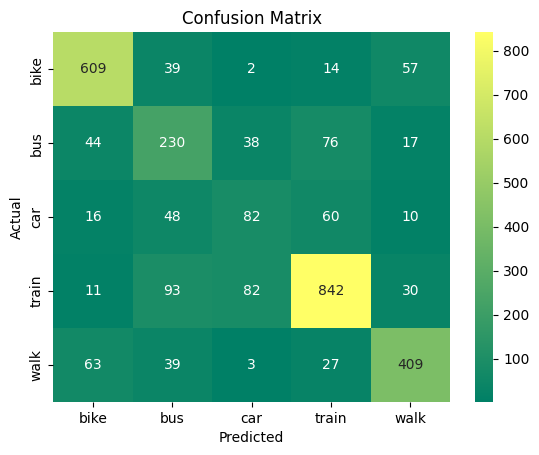

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(scaled_features,target_feature,test_size=0.2,random_state=40)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

model = DecisionTreeClassifier(criterion='gini',
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='sqrt')

model.fit(X_train,y_train)
dt_pred=model.predict(X_test)
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
result_tree=cross_val_score(model,scaled_features,target_feature,cv=10,scoring='accuracy')
print('The overall score for Decision Tree classifier is:',round(result_tree.mean()*100,2), "\n")
y_pred = cross_val_predict(model,scaled_features,target_feature,cv=10)
class_labels = model.classes_
sns.heatmap(confusion_matrix(y_test, dt_pred),
            annot=True,
            cmap='summer',
            fmt='g',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [ ]:
print(classification_report(y_test, dt_pred, target_names=class_labels))

              precision    recall  f1-score   support

        bike       0.82      0.84      0.83       721
         bus       0.51      0.57      0.54       405
         car       0.40      0.38      0.39       216
       train       0.83      0.80      0.81      1058
        walk       0.78      0.76      0.77       541

    accuracy                           0.74      2941
   macro avg       0.67      0.67      0.67      2941
weighted avg       0.74      0.74      0.74      2941



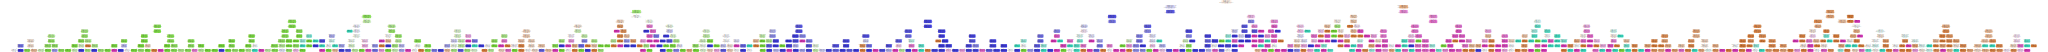

In [ ]:
# # Visualize the tree by graphiz

# dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=features, class_names=class_names)
# graph = graphviz.Source(dot_data)
# graph

### **Decision Tree v3**

This code is bases from: https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/



### Next Step: ML - Support Vector Machine